In [4]:
from casadi import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [5]:
def opti_fixedT(m_l=0.5, k=3000, tau_max=0.05, omega_max=3000, t=0.2, ics=(0,0,0), guess=(0.0003, 5)):
    opti = Opti()
    T1 = opti.variable()
    T2 = opti.variable()

    x_a0 = opti.parameter()
    opti.set_value(x_a0, ics[0])
    x_l0 = opti.parameter()
    opti.set_value(x_l0, ics[1])
    v_l0 = opti.parameter()
    opti.set_value(v_l0, ics[2])

    x0 = 1/T2
    x1 = T2**2
    x2 = omega_max**2
    x3 = x1*x2
    x4 = k**2
    x5 = m_l**2
    x6 = T1**4*x5
    x7 = x4*x6
    x9 = 1/tau_max
    x10 = (1/2)*x9
    x12 = T1**2
    x13 = omega_max*t
    x14 = k*x10*x12*x13
    x15 = exp(x14)
    x16 = tau_max*x15
    x17 = x16*x_a0
    x18 = T1*omega_max
    x19 = T2*m_l*v_l0*x18
    x20 = m_l*x12
    x21 = x20*x3
    x22 = k*m_l
    x23 = 2*tau_max
    x24 = x23*x_l0
    x25 = x12*x22
    x26 = x23*x_a0
    x27 = T2*omega_max
    x28 = T2**3
    x29 = omega_max**3
    x30 = T1**3
    x32 = exp(-x14)
    x33 = x32*x9
    x34 = x1*x18
    x35 = T2*v_l0 - x34
    x36 = 2*k
    x37 = T1*T2
    x38 = omega_max*x1
    x39 = 2*v_l0*x25*x38
    x40 = x2*x28
    x41 = x22*x30*x40
    x42 = 2*x41
    x43 = tau_max*x36
    x44 = -x37*x43*x_a0 + x43*x_l0

    r = 4*k*m_l*tau_max**2 - x3*x7
    R_ad_re = if_else(r>0, sqrt(r), 0)
    R_ad_im = if_else(r>0, 0, sqrt(-r))

    x11_re = t*x0*x10*R_ad_re/m_l
    x11_im = t*x0*x10*R_ad_im/m_l

    C_os = cos(x11_re)*cosh(x11_im)
    S_in_re = sin(x11_re)*cosh(x11_im)
    S_in_im = cos(x11_re)*sinh(x11_im)

    SdR = (S_in_re*R_ad_re + S_in_im*R_ad_im) / (R_ad_re**2 + R_ad_im**2) # S_in/R_ad should be purely real (aka x31)
    SmR = S_in_re*R_ad_re - S_in_im*R_ad_im  # S_in*R_ad should be purely real

    x_a = x33*(C_os*(-x19 + x21) + x13*x16 + x15*x19 - x15*x21 + x17 + SdR*(-k*v_l0*x3*x30*x5 + k*x28*x29*x6 + x18*x22*x24 - x25*x26*x27))
    x_l = (1/2)*x33*(C_os*(-x39 + x42 + x44) + SmR*x35 + T2*t*x16*x18*x36 + x15*x39 - x15*x42 + x17*x36*x37 + SdR*(T1**5*T2**4*x29*x4*x5 - m_l*x26*x30*x38*x4 - v_l0*x40*x7 + x20*x24*x27*x4))/k
    v_l = x0*x32*(C_os*x35 + x15*x34 + SdR*(k*m_l*omega_max*v_l0*x1*x12 - x41 - x44))

    opti.minimize(-v_l)
    opti.subject_to(opti.bounded(1e-6, T1, 0.001))
    opti.subject_to(opti.bounded(1e-6, T2, 20))
    opti.set_initial(T1, guess[0])
    opti.set_initial(T2, guess[1])

    log = []
    opti.callback(lambda i: log.append((opti.debug.value(T1), opti.debug.value(T2), opti.debug.value(v_l))))

    opts = {'ipopt.print_level':0, 'print_time':0}
    opti.solver('ipopt', opts)
    sol = opti.solve()

    return sol, np.array(log), opti, (T1, T2)

sol, log, opti, (T1, T2) = opti_fixedT(guess=(np.random.uniform(1e-6, 0.001), np.random.uniform(1e-6, 20)))
log

array([[4.77438899e-04, 1.27027888e+01, 2.72201370e+00],
       [4.33762467e-04, 1.27027888e+01, 2.88693582e+00],
       [3.34793142e-04, 7.66727293e+00, 4.62095961e+00],
       [3.85685819e-04, 5.80794018e+00, 4.99764233e+00],
       [3.93391147e-04, 6.29904386e+00, 4.84952555e+00],
       [3.93889521e-04, 6.42200547e+00, 4.81154093e+00],
       [3.57391224e-04, 5.01585102e+00, 5.10225150e+00],
       [3.45680657e-04, 5.28694359e+00, 5.11245580e+00],
       [3.39731039e-04, 5.37485981e+00, 5.11288298e+00],
       [3.40093005e-04, 5.37321359e+00, 5.11285047e+00],
       [3.37055318e-04, 5.36230307e+00, 5.11316283e+00],
       [3.36958720e-04, 5.36314736e+00, 5.11316315e+00],
       [3.36779414e-04, 5.36263592e+00, 5.11316406e+00],
       [3.36779112e-04, 5.36263852e+00, 5.11316406e+00],
       [3.36776880e-04, 5.36263225e+00, 5.11316406e+00],
       [3.36776880e-04, 5.36263225e+00, 5.11316406e+00]])

interactive(children=(FloatSlider(value=0.55, description='m_l', max=1.0, min=0.1, step=0.01), IntSlider(value…

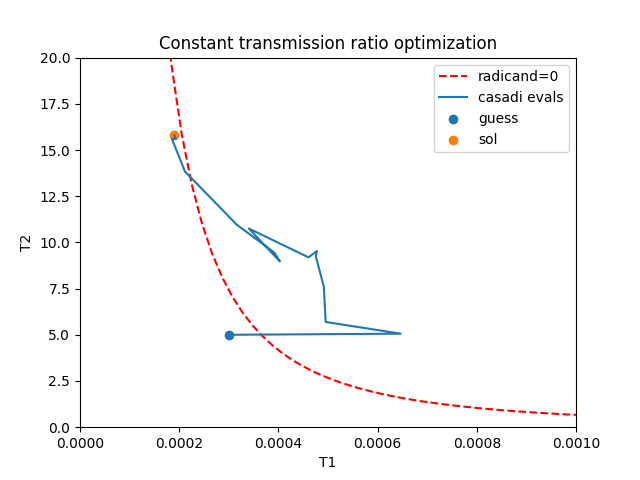

In [9]:
from ipywidgets import interact

plt.figure()
plt.xlim(0, 100)
plt.ylim(0, 100)
def plot_opti(m_l, k, tau_max, omega_max, t, x_a0, x_l0, v_l0):
    plt.clf()

    sol, log, opti, (T1, T2) = opti_fixedT(m_l, k, tau_max, omega_max, t, ics=[x_a0, x_l0, v_l0])
    T1s = log[:,0]
    T2s = log[:,1]
    v_ls = log[:,2]

    radicandT1 = np.linspace(1e-6, 0.001, 50)
    radicandT2 = sqrt(4*k*m_l*tau_max**2 / (radicandT1**4*k**2*m_l**2*omega_max**2))

    plt.plot(radicandT1, radicandT2, 'r--', label='radicand=0')
    plt.plot(T1s, T2s, label='casadi evals')
    plt.scatter(opti.debug.value(T1,opti.initial()), opti.debug.value(T2,opti.initial()), label='guess')
    plt.scatter(sol.value(T1), sol.value(T2), label='sol')
    plt.title("Constant transmission ratio optimization")
    plt.xlabel("T1")
    plt.ylabel("T2")
    plt.xlim(0, 0.001)
    plt.ylim(0, 20)
    plt.legend(loc='upper right')

interact(
    plot_opti, 
    m_l=(0.1, 1, 0.01), 
    k=(1000, 10000, 10), 
    tau_max=(0.01, 0.1, 0.001),
    omega_max=(1000, 5000, 1),
    t=(0.1, 0.5, 0.001),
    x_a0=(0, 1000, 1),
    x_l0=(0, 0.3, 0.001),
    v_l0=(0, 5, 0.01)
)
print("")